You can order print and ebook versions of *Think Bayes 2e* from
[Bookshop.org](https://bookshop.org/a/98697/9781492089469) and
[Amazon](https://amzn.to/334eqGo).

# Bread

In [1]:
# install empiricaldist if necessary

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist
    import empiricaldist

In [2]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az


from utils import decorate, set_pyplot_params

set_pyplot_params()

This notebook is based on an exercise from [Chapter 7](https://allendowney.github.io/ThinkBayes2/chap07.html):

> Henri Poincaré was a French mathematician who taught at the Sorbonne around 1900. The following anecdote about him is probably fiction, but it makes an interesting probability problem.
> 
> Supposedly Poincaré suspected that his local bakery was selling loaves of bread that were lighter than the advertised weight of 1 kg, so every day for a year he bought a loaf of bread, brought it home and weighed it. At the end of the year, he plotted the distribution of his measurements and showed that it fit a normal distribution with mean 950 g and standard deviation 50 g. He brought this evidence to the bread police, who gave the baker a warning.
> 
> For the next year, Poincaré continued to weigh his bread every day. At the end of the year, he found that the average weight was 1000 g, just as it should be, but again he complained to the bread police, and this time they fined the baker.
> 
> Why? Because the shape of the new distribution was asymmetric. Unlike the normal distribution, it was skewed to the right, which is consistent with the hypothesis that the baker was still making 950 g loaves, but deliberately giving Poincaré the heavier ones.
> 
> To see whether this anecdote is plausible, let's suppose that when the baker sees Poincaré coming, he hefts `n` loaves of bread and gives Poincaré the heaviest one.  How many loaves would the baker have to heft to make the average of the maximum 1000 g?


Notes on the origin of this example:

* I don't remember where I got it from, but it appears in Leonard Mlodinov, *The Drunkard's Walk* (2008).

* Mlodinov credits Bart Holland, *What Are the Chances?* (2002)...

* The ultimate source seems to be George Gamow and M. Stern, *Puzzle Math* ()

In [4]:
from scipy.stats import norm
from empiricaldist import Pmf

def make_normal_pmf(mu, sigma):
    qs = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 201)
    ps = norm.pdf(qs, mu, sigma)

    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [5]:
mu = 950
sigma = 50

pdf = make_normal_pmf(mu, sigma)
pdf_max = pdf.max_dist(4)

In [6]:
mean, std = pdf_max.mean(), pdf_max.std()
mean, std

(np.float64(1001.4477050259824), np.float64(35.02214971805517))

In [7]:
pdf_match = make_normal_pmf(mean, std)

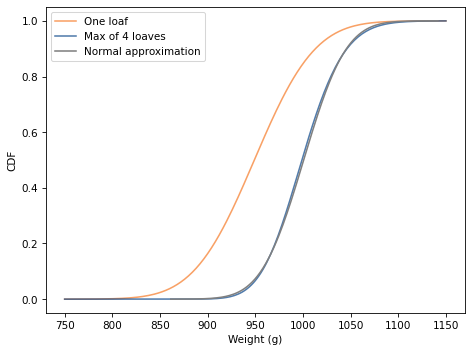

In [8]:
pdf.make_cdf().plot(label='One loaf', color='C1')
pdf_max.make_cdf().plot(label='Max of 4 loaves')
pdf_match.make_cdf().plot(label='Normal approximation', color='gray')
decorate(xlabel='Weight (g)', ylabel='CDF')

Here's the mean of the maximum of `n` loaves, for a range of values of `n`

In [12]:
mu_true, sigma_true, n_true = 950, 50, 4

sample1 = norm(mu_true, sigma_true).rvs((365, n_true)).max(axis=1)
sample1.mean(), sample1.std()

(np.float64(1001.2085846213959), np.float64(35.32712297555484))

In [54]:
from empiricaldist import Cdf

def compare_sample(sample):
    n = len(sample)
    mean, std = sample.mean(), sample.std()
    dist = norm(mean, std)
    
    for i in range(10):
        normal_sample = dist.rvs(n)
        cdf = Cdf.from_seq(normal_sample)
        cdf.plot(color='gray', alpha=0.1)

    cdf = Cdf.from_seq(sample)
    cdf.plot(label=f'Max of 4 loaves, sample size {n}')

    decorate(xlabel='Weight (g)', ylabel='CDF')

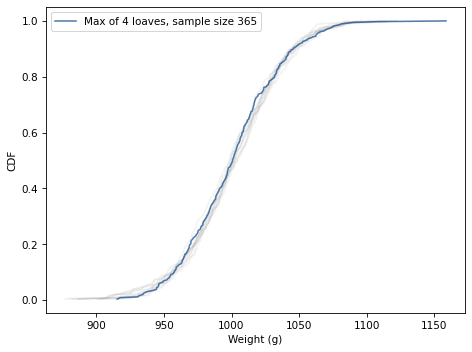

In [55]:
compare_sample(sample1)

In [56]:
sample2 = norm(mu_true, sigma_true).rvs((365 * 10, n_true)).max(axis=1)
sample2.mean(), sample1.std()

(np.float64(1001.46778237084), np.float64(35.32712297555484))

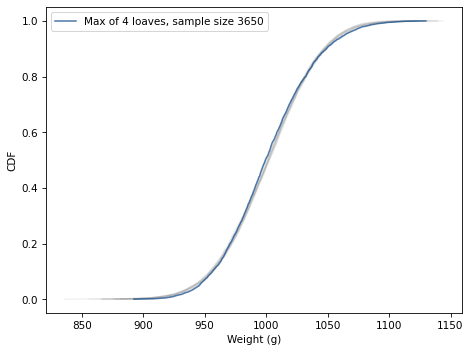

In [57]:
compare_sample(sample2)

Maximum of $n$ draws from Normal(μ, σ)

If each draw has CDF $F(m)$, then the CDF of the maximum is
$$
F_M(m) = [F(m)]^n.
$$

Differentiate to get the PDF:
$$
f_M(m) = n\, [F(m)]^{\,n-1}\, f(m).
$$

For $X \sim \mathcal N(\mu,\sigma)$

$$
f(m) = \frac{1}{\sigma}\,\phi(z),\qquad F(m)=\Phi(z),
$$

where $\phi$ and $\Phi$ are the standard normal PDF and CDF, and $z$ is the standardized value , define $z=(m-\mu) / \sigma$.

Plugging in,
$$
f_M(m)
= n \cdot \frac{1}{\sigma} \phi(z) [\Phi(z)]^{n-1}
$$

Here's a function that evaluates the log PDF at $x$.

In [88]:

LOG2PI = np.log(2 * np.pi)

def max_normal_logp(x, mu, sigma, n):
    """
    Alternative using PyTensor's more advanced functions.
    """
    z = (x - mu) / sigma
    log_phi = -0.5 * z**2 - 0.5 * LOG2PI
    
    # Use PyTensor's erfc for better numerical stability
    # log(Φ(z)) = log(0.5 * (1 + erf(z/√2))) = log(0.5 * erfc(-z/√2))
    Phi = 0.5 * pm.math.erfc(-z / pm.math.sqrt(2))
    log_Phi = pm.math.log(Phi)
    
    return pm.math.log(n) - pm.math.log(sigma) + log_phi + (n - 1) * log_Phi

In [89]:
def make_model(sample):
    with pm.Model() as model:
        mu = pm.Normal("mu", mu=950, sigma=30)
        sigma = pm.HalfNormal("sigma", sigma=30)
        n = pm.Uniform("n", lower=1, upper=15)

        obs = pm.CustomDist(
            "obs",
            mu, sigma, n,
            logp=max_normal_logp,
            observed=sample,
        )
    return model

In [95]:
model = make_model(sample1)
with model:
    trace = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, n]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [96]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,934.572,20.899,896.111,972.778,0.873,0.493,566.0,855.0,1.01
sigma,53.846,5.594,43.705,64.326,0.225,0.127,614.0,910.0,1.01
n,6.218,2.914,1.847,12.205,0.121,0.090,575.0,722.0,1.01


In [132]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

def plot_posterior(trace, var_name, x_true):
    # Extract posterior samples for 'mu'
    samples = az.extract(trace)[var_name].to_numpy()

    # KDE over posterior samples
    kde = gaussian_kde(samples)

    # Define x-range for plotting
    qs = np.linspace(samples.min(), samples.max(), 200)
    ps = kde(qs)

    # Evaluate posterior density at the true value
    p_true = kde(x_true) * 0.5

    # Plot the KDE
    az.plot_posterior(trace, var_names=var_name, hdi_prob='hide')

    # Plot vertical line at true value, matching KDE height
    plt.vlines(x_true, 0, p_true, ls=':', color='gray')
    plt.text(x_true, p_true, f'actual={x_true}', ha='right', fontsize=16)
    decorate()

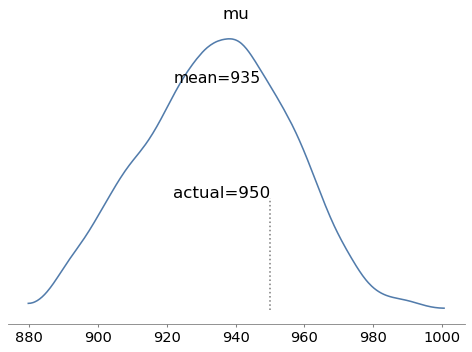

In [134]:
plot_posterior(trace, 'mu', mu_true)


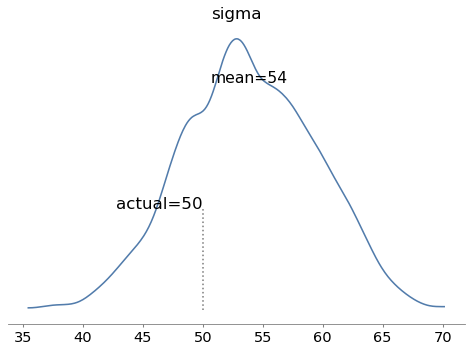

In [133]:
plot_posterior(trace, 'sigma', sigma_true)


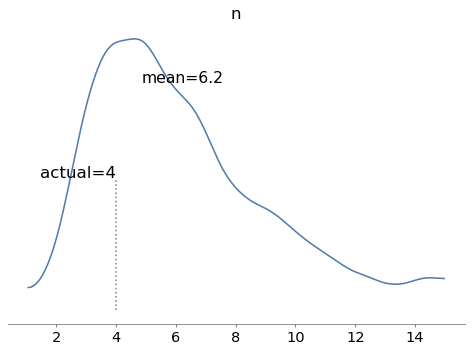

In [135]:
plot_posterior(trace, 'n', n_true)


*Think Bayes*, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)